Final project: Average reservoir pressure estimation of using dynamic data

In [1]:
import os
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [48]:
caminho_arquivo = 'dados_prod.xlsx'

# Usando o método read_excel para ler o arquivo .xlsx em um DataFrame
df = DataFrame(pd.read_excel(caminho_arquivo, header=0))

#Vamos utilizar o valor absoluto da pressão média para uma primeira avaliação

y = df['P_ajustada'].values

# Agora você pode usar o 'dataframe' para trabalhar com os dados do arquivo .xlsx
df.head()

Data  Dias  P_ajustada   P_medida  MRO-3 Qo (m³/d)  \
0 2021-08-03     0  628.842403  628.91328              0.0   
1 2021-08-04     0  628.845835  628.91028              0.0   
2 2021-08-05     1  628.849198  628.90728              0.0   
3 2021-08-06     2  628.852492  628.90528              0.0   
4 2021-08-07     3  628.855718  628.90228              0.0   

   MRO-3 Qg (mil m³/d)  MRO-3 Qw (m³/d)  MRO-6 Qo (m³/d)  MRO-6 Qg (mil m³/d)  \
0                  0.0              0.0              0.0                  0.0   
1                  0.0              0.0              0.0                  0.0   
2                  0.0              0.0              0.0                  0.0   
3                  0.0              0.0              0.0                  0.0   
4                  0.0              0.0              0.0                  0.0   

   MRO-6 Qw (m³/d)  ...  MRO-6 Gp  MRO-6 Wp  MRO-7 Np  MRO-7 Gp  MRO-7 Wp  \
0              0.0  ...       0.0       0.0       0.0       0.0       0.0   
1              0.0  ...       0.0       0.0       0.0       0.0       0.0   
2              0.0  ...       0.0       0.0       0.0       0.0       0.0   
3              0.0  ...       0.0       0.0       0.0       0.0       0.0   
4              0.0  ...       0.0       0.0       0.0       0.0       0.0   

   MRO-10 Np  MRO-10 Gp  MRO-10 Wp  RJS-743 Gi  MRO-11 Wi  
0        0.0        0.0        0.0         0.0        0.0  
1        0.0        0.0        0.0         0.0        0.0  
2        0.0        0.0        0.0         0.0        0.0  
3        0.0        0.0        0.0         0.0        0.0  
4        0.0        0.0        0.0         0.0        0.0  

[5 rows x 32 columns]

In [18]:
#Definindo a matriz dos dados de entrada

matriz_entrada = list(df.columns)[4:]

X1 = df[matriz_entrada].values
scaler = MinMaxScaler(feature_range=(0,1))
X1s = scaler.fit_transform(X1)

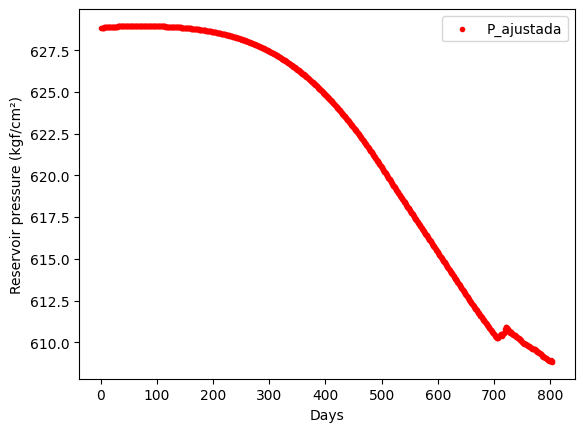

In [19]:
dias = range(1,805)

plt.scatter(dias, y, label = 'P_ajustada', color = 'r', marker = '.')
plt.legend()
plt.ylabel('Reservoir pressure (kgf/cm²)')
plt.xlabel('Days')
plt.show()

In [20]:
pca = PCA()
pca.fit(X1s)

PCA()

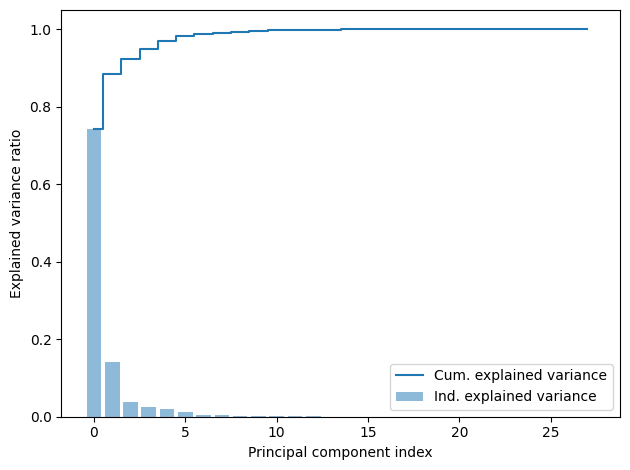

In [21]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_variance = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',label='Ind. explained variance')
plt.step(range(0,len(cum_sum_variance)), cum_sum_variance, where='mid', label='Cum. explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [25]:
X1_reduced=pca.fit_transform(X1s)
componentes=len(cum_sum_variance[cum_sum_variance<0.99])
#componentes = 5
X2=X1_reduced[:,0:componentes]
X2.shape

(804, 7)

Testando alguns modelos de regressão

In [34]:
from scipy import stats
from scipy.stats import mode
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, RepeatedKFold, 
RandomizedSearchCV)
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
#Define models

models = []
models.append(("LRG", Ridge()))
models.append(("SVR", SVR()))
models.append(("KNN", KNeighborsRegressor()))

#Define hyperparams to be tested

param_grids = []

param_grids.append(
    [
        {
            "LRG__alpha": stats.loguniform(1e-1, 1e1),
            "LRG__solver" : ['auto']
        }
    ]
)

param_grids.append(
    [
        {
            "SVR__C" : stats.loguniform(1e-1, 1e1),
            "SVR__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
            "SVR__degree" : stats.randint(2, 5),
            "SVR__gamma" : stats.loguniform(1e-4, 1e0),
        }
    ]
)

param_grids.append(
    [
        {
            "KNN__n_neighbors" : stats.randint(2, 5),
            "KNN__weights" : ['uniform', 'distance'],
            "KNN__algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        }
    ]
)



In [36]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.4, random_state=42)

rkf = RepeatedKFold(n_splits = 5, n_repeats = 50, random_state = 0)

best_params = []
yh_test_loop = []
y_test_loop = []

for k in range(len(models)):
        
    clf = Pipeline([(models[k])])
    
    param_grid = param_grids[k]
    
    random_search = RandomizedSearchCV(clf, verbose = True, scoring = 'neg_mean_squared_error', param_distributions = param_grid, 
                                       n_iter = 100, n_jobs = -1, cv = rkf, random_state = 0)

    random_search.fit(X_train, y_train)
    
    yh_test = random_search.predict(X_test)
    
    yh_test_loop.append(yh_test)
    y_test_loop.append(y_test)
    
    best_params.append(random_search.best_params_)

Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Fitting 250 folds for each of 100 candidates, totalling 25000 fits


In [37]:
print(best_params)

for i in range(len(models)):
    print(models[i][0])
    print(mean_squared_error(y_test_loop[i], yh_test_loop[i]))

[{'LRG__alpha': 0.10218589483781249, 'LRG__solver': 'auto'}, {'SVR__C': 7.119112572276267, 'SVR__degree': 2, 'SVR__gamma': 0.6478622717477827, 'SVR__kernel': 'rbf'}, {'KNN__algorithm': 'brute', 'KNN__n_neighbors': 4, 'KNN__weights': 'distance'}]
LRG
0.2650283746630675
SVR
0.06186181483254347
KNN
0.12055209171681672


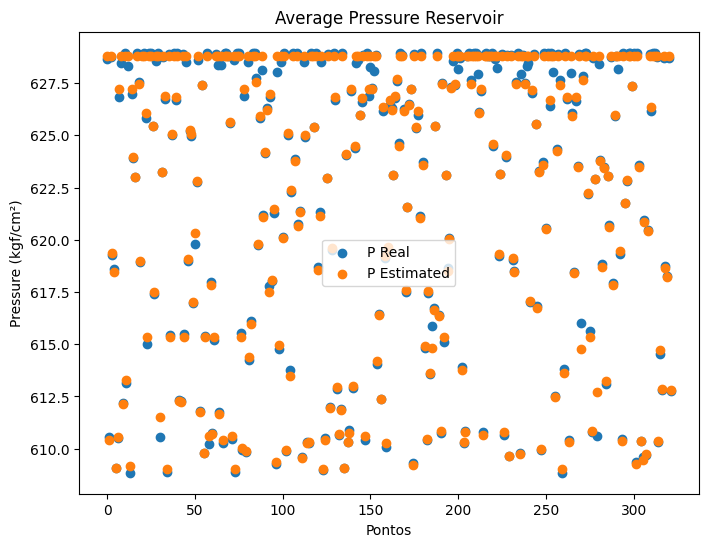

In [38]:
dados = range(yh_test_loop[0].shape[0])

plt.figure(figsize=(8, 6))
plt.scatter(dados, y_test_loop[1], label='P Real')
plt.scatter(dados, yh_test_loop[1], label='P Estimated')

# Personalizar o gráfico
plt.title('Average Pressure Reservoir')
plt.xlabel('Pontos')
plt.ylabel('Pressure (kgf/cm²)')
plt.legend()

# Mostrar o gráfico
plt.show()


In [39]:
#Aqui ele usa o random_search com os parâmetros do último modelo testado, no caso o SVM
yh = random_search.predict(X2)

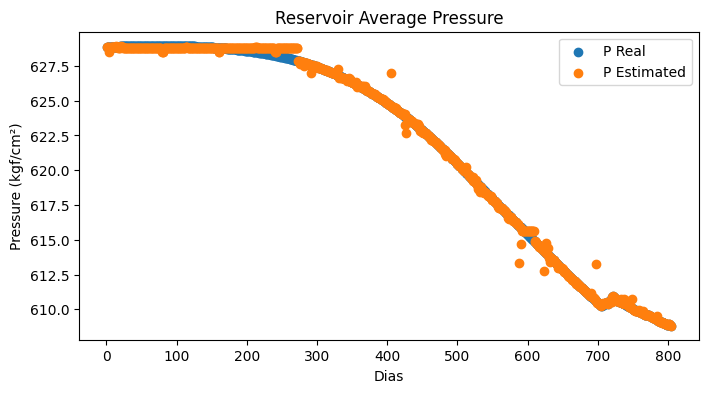

In [40]:
dias = range(1,805)

plt.figure(figsize=(8, 4))
plt.scatter(dias, y, label='P Real')
plt.scatter(dias, yh, label='P Estimated')

# Personalizar o gráfico
plt.title('Reservoir Average Pressure')
plt.xlabel('Dias')
plt.ylabel('Pressure (kgf/cm²)')
plt.legend()

# Mostrar o gráfico
plt.show()

Fitting 250 folds for each of 100 candidates, totalling 25000 fits


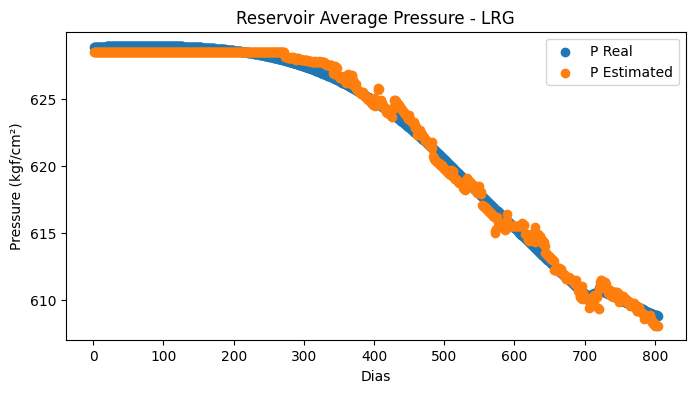

In [42]:
#Verificando LRG:

clf = Pipeline([(models[0])])
        
random_search = RandomizedSearchCV(clf, verbose = True, scoring = 'neg_mean_squared_error', param_distributions = param_grids[0], 
                                       n_iter = 100, n_jobs = -1, cv = rkf, random_state = 0)

random_search.fit(X_train, y_train)

yh_LRG = random_search.predict(X2)

dias = range(1,805)

plt.figure(figsize=(8, 4))
plt.scatter(dias, y, label='P Real')
plt.scatter(dias, yh_LRG, label='P Estimated')

# Personalizar o gráfico
plt.title('Reservoir Average Pressure - LRG')
plt.xlabel('Dias')
plt.ylabel('Pressure (kgf/cm²)')
plt.legend()

# Mostrar o gráfico
plt.show()


Fitting 250 folds for each of 100 candidates, totalling 25000 fits


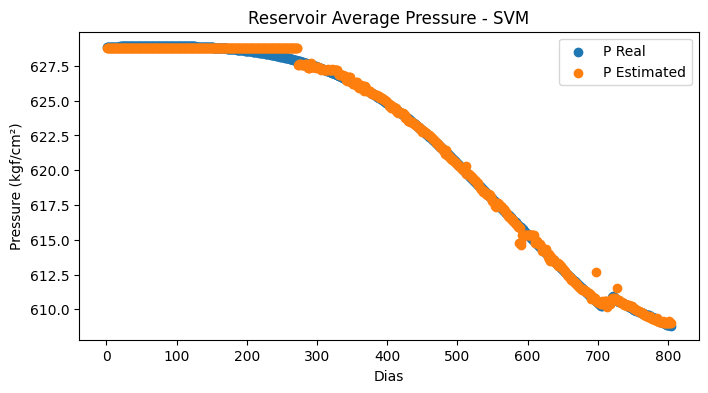

In [45]:
#Verificando SVM:

clf = Pipeline([(models[1])])
        
random_search_2 = RandomizedSearchCV(clf, verbose = True, scoring = 'neg_mean_squared_error', param_distributions = param_grids[1], 
                                       n_iter = 100, n_jobs = -1, cv = rkf, random_state = 0)

random_search_2.fit(X_train, y_train)

yh_SVM = random_search_2.predict(X2)

dias = range(1,805)

plt.figure(figsize=(8, 4))
plt.scatter(dias, y, label='P Real')
plt.scatter(dias, yh_SVM, label='P Estimated')

# Personalizar o gráfico
plt.title('Reservoir Average Pressure - SVM')
plt.xlabel('Dias')
plt.ylabel('Pressure (kgf/cm²)')
plt.legend()

# Mostrar o gráfico
plt.show()


Fitting 250 folds for each of 100 candidates, totalling 25000 fits


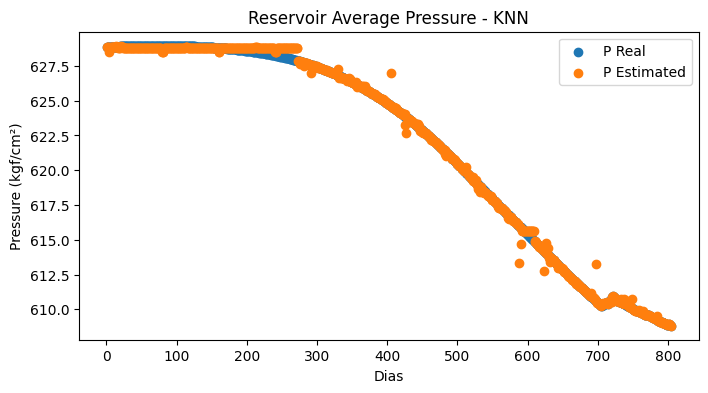

In [46]:
#Verificando KNN:

clf = Pipeline([(models[2])])
        
random_search_3 = RandomizedSearchCV(clf, verbose = True, scoring = 'neg_mean_squared_error', param_distributions = param_grids[2], 
                                       n_iter = 100, n_jobs = -1, cv = rkf, random_state = 0)

random_search_3.fit(X_train, y_train)

yh_KNN = random_search_3.predict(X2)

dias = range(1,805)

plt.figure(figsize=(8, 4))
plt.scatter(dias, y, label='P Real')
plt.scatter(dias, yh_KNN, label='P Estimated')

# Personalizar o gráfico
plt.title('Reservoir Average Pressure - KNN')
plt.xlabel('Dias')
plt.ylabel('Pressure (kgf/cm²)')
plt.legend()

# Mostrar o gráfico
plt.show()
